# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [40]:
import xarray as xr
import rioxarray as rio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mode

from pathlib import Path
from matplotlib.gridspec import GridSpec


In [3]:
# paths
data_path = Path('../../data/')
log_path = Path('../../runs/')
figure_path = Path('../../LaTex/figures/')

# coordinates
csr = 'EPSG:2056'

# filter warnings
warnings.filterwarnings("ignore", message="angle from rectified to skew grid parameter lost in conversion to CF")


In [59]:
# function to reduce plotting resolution

def mode_reduction(block, axis):
        # Flatten the block and calculate the mode
        dim0, dim1, dim2, dim3 = block.shape
        flattened = block.transpose((0, 2, 1, 3)).reshape(dim0, dim2, -1)
        result = mode(flattened, axis=-1, nan_policy='omit').mode
        return result

def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    if reduction == 'mode':
        return da.coarsen(x=factor, y=factor, boundary="trim").reduce(mode_reduction).compute()
    else:
        return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


## Visualizations of the available Data

### Size of the 3 areas

In [5]:
# import .shp file
gdf = gpd.read_file(data_path / 'BL_QA_editedJK.shp')


In [6]:
# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

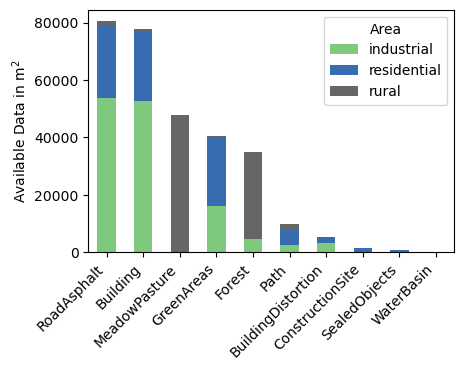

In [7]:
fig_filename = 'area_by_category.pdf'
image_size_cm = [12, 8]

fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Aggregate the grouped data
data = gdf.groupby(['QA_categor', 'area'])['Shape_Area'].sum().unstack().fillna(0)

# Sort the data by the total size of each QA_categor
data['Total'] = data.sum(axis=1)
data = data.sort_values('Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart
data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

ax.set_xlabel(None)
ax.set_ylabel('Available Data in m$^2$')
ax.legend(title='Area')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig(figure_path / fig_filename, bbox_inches='tight')
plt.show()


## Visualizations of the Results

### Loss and accuracy

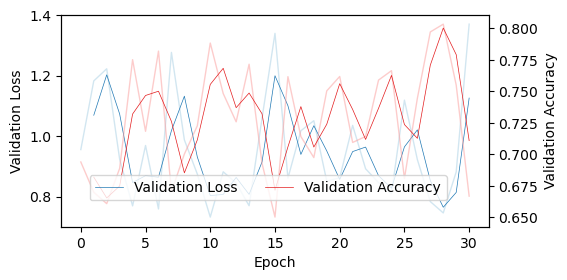

In [8]:
run = 'noaugment_complete'
metrics = pd.read_csv(log_path / run / 'metrics.csv')
image_size_cm = [14, 7]

validation_data = metrics[~metrics['valid_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['valid_loss'], window_size=2)
smoothed_val_acc = smooth_data(validation_data['valid_acc'], window_size=2)

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Plot unsmoothed valid_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['valid_loss'], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot valid_acc
ax2 = ax1.twinx()
# Plot unsmoothed valid_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['valid_acc'], color='#FB9A99', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=0.5)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)


### Visualizations of the Predictions

In [9]:
# load training data
ds_training = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
ds_training["label"] = ds_training["label"].where(ds_training["label"] != 255, np.nan)

areas = gpd.read_file(data_path / 'AOI_Labeled.shp')


In [16]:
# load predictions

run = 'noaugment_complete'
ds_predictions = xr.open_zarr(log_path / run / 'preds.zarr').rio.write_crs(csr).rename({"label_pred": "label"})


In [66]:
def plot_labels_and_predictions(training: xr.Dataset, predictions: xr.Dataset):
    # Image size in centimeters
    image_size_cm = [18, 10]

    # Create GridSpec layout
    fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], figure=fig)

    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    cax = fig.add_subplot(gs[0, 2])

    im1 = training.plot(vmin=0, vmax=9, ax=ax1, add_colorbar=False, cmap='Pastel1')
    im2 = predictions.plot(vmin=0, vmax=9, ax=ax2, add_colorbar=False, cmap='Pastel1')

    # colorbar
    cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
    cbar.set_label('Class')  # Label for the colorbar

    # Set axis titles
    ax1.set_title('Labels')
    ax2.set_title('Predictions')

    # Set proper axis labels for EPSG:2056
    ax1.set_xlabel('Eastings (m)')
    ax1.set_ylabel('Northings (m)')
    ax2.set_xlabel('Eastings (m)')
    ax2.set_ylabel(None)
    ax2.set_yticks([])

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return fig

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


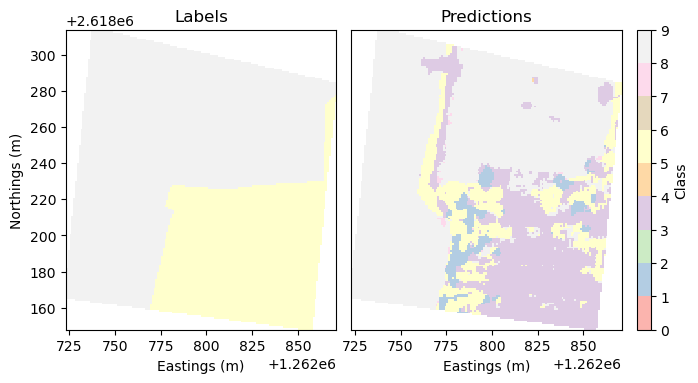

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


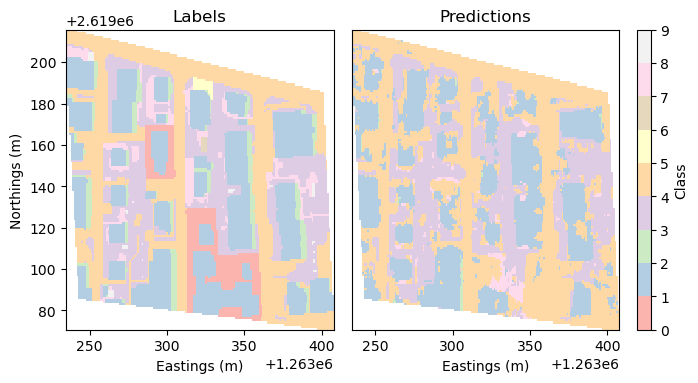

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


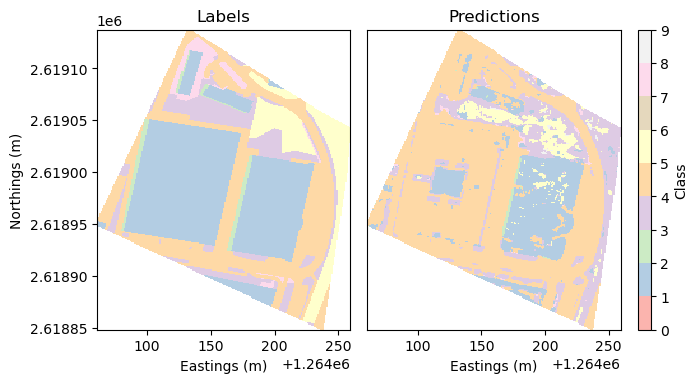

In [67]:
figures = []

trainLabels = [4, 8, 12]

for label in trainLabels:
    selectedDataLabel = label

    clip_feature = areas[areas['DataLabel'] == selectedDataLabel]
    clipped_training = ds_training.rio.clip(clip_feature.geometry, clip_feature.crs)
    clipped_predictions = ds_predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

    # Coarsen and plot with shared colorbar
    training_coarsened = coarsen(clipped_training['label'], reduction='mode')
    predictions_coarsened = coarsen(clipped_predictions['label'], reduction='mode')

    figure = plot_labels_and_predictions(training_coarsened, predictions_coarsened)
    figures.append(figure)


In [44]:
selectedDataLabel = 8

clip_feature = areas[areas['DataLabel'] == selectedDataLabel]
clipped_training = ds_training.rio.clip(clip_feature.geometry, clip_feature.crs)
clipped_predictions = ds_predictions.rio.clip(clip_feature.geometry, clip_feature.crs)


KeyboardInterrupt: 

In [60]:

# Coarsen and plot with shared colorbar
training_coarsened = coarsen(clipped_training['label'], reduction = 'mode')
predictions_coarsened = coarsen(clipped_predictions['label'], reduction = 'mode')

C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode
C:\Users\kraft\AppData\Local\Temp\ipykernel_4860\2678193572.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  result = mode(flattened, axis=-1, nan_policy='omit').mode


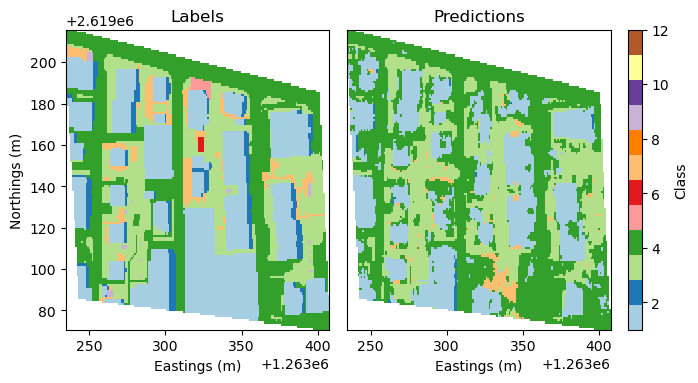

In [65]:
image_size_cm = [18, 10]

# Create GridSpec layout
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

im1 = training_coarsened.plot(vmin=1, vmax=12, ax=ax1, add_colorbar=False, cmap='Paired')
im2 = predictions_coarsened.plot(vmin=1, vmax=12, ax=ax2, add_colorbar=False, cmap='Paired')

# colorbar
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.set_label('Class')  # Label for the colorbar

# Set axis titles
ax1.set_title('Labels')
ax2.set_title('Predictions')

# Set proper axis labels for EPSG:2056
ax1.set_xlabel('Eastings (m)')
ax1.set_ylabel('Northings (m)')
ax2.set_xlabel('Eastings (m)')
ax2.set_ylabel(None)
ax2.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()